In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 9.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 3.12 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.5 ; cuda:  cu124
detectron2: 0.6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [ ]:
database_path = "/content/drive/MyDrive/Scatter Dataset"
train_annotations = os.path.join(database_path, "train", "annotations", "instances_default.json")
val_annotations = os.path.join(database_path, "val", "annotations", "instances_default.json")
train_images = os.path.join(database_path, "train", "images")
val_images = os.path.join(database_path, "val", "images")

In [ ]:
register_coco_instances("scatter_train", {}, train_annotations, train_images)
register_coco_instances("scatter_val", {}, val_annotations, val_images)

In [ ]:
dataset_dicts = DatasetCatalog.get("scatter_train")
scatter_metadata = MetadataCatalog.get("scatter_val")

In [16]:
scatter_metadata.thing_classes = ["title", "canvas", "x-labels", "y-labels", "x-title", "y-title", "legend", "scale", "other text", "quantity"]

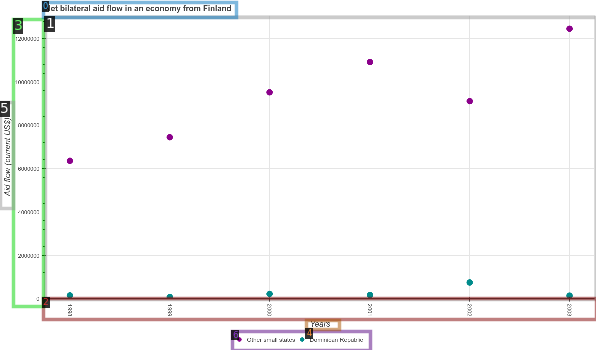

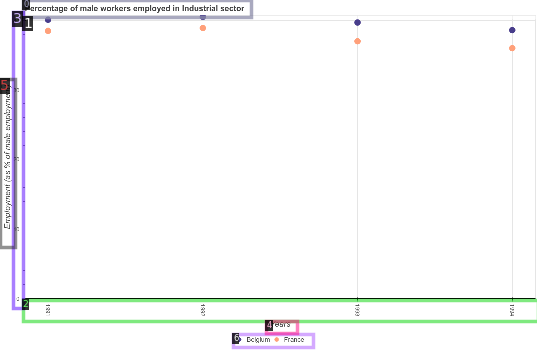

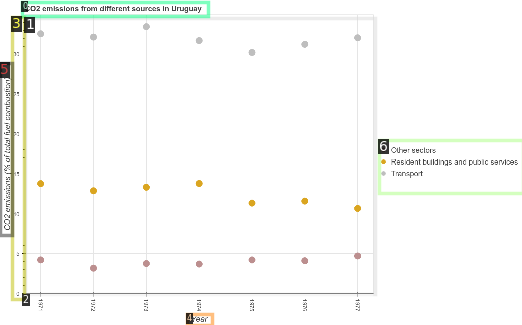

In [ ]:
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=scatter_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("scatter_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/22 03:35:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 124MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/22 03:35:27 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/22 03:35:45 d2.utils.events]:  eta: 0:12:11  iter: 19  total_loss: 6.071  loss_cls: 2.432  loss_box_reg: 0.1634  loss_rpn_cls: 2.845  loss_rpn_loc: 0.6355    time: 0.7200  last_time: 0.6991  data_time: 0.2954  last_data_time: 0.2013   lr: 4.9953e-06  max_mem: 2635M
[02/22 03:36:04 d2.utils.events]:  eta: 0:11:52  iter: 39  total_loss: 4.476  loss_cls: 2.206  loss_box_reg: 0.1866  loss_rpn_cls: 1.573  loss_rpn_loc: 0.5581    time: 0.7228  last_time: 1.1694  data_time: 0.2875  last_data_time: 0.7148   lr: 9.9902e-06  max_mem: 2635M
[02/22 03:36:18 d2.utils.events]:  eta: 0:10:50  iter: 59  total_loss: 3.139  loss_cls: 1.87  loss_box_reg: 0.2962  loss_rpn_cls: 0.4168  loss_rpn_loc: 0.5018    time: 0.7154  last_time: 0.6672  data_time: 0.2299  last_data_time: 0.1964   lr: 1.4985e-05  max_mem: 2636M
[02/22 03:36:30 d2.utils.events]:  eta: 0:10:11  iter: 79  total_loss: 2.36  loss_cls: 1.421  loss_box_reg: 0.3795  loss_rpn_cls: 0.101  loss_rpn_loc: 0.4369    time: 0.6829  last_time: 0.42

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[02/22 03:44:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

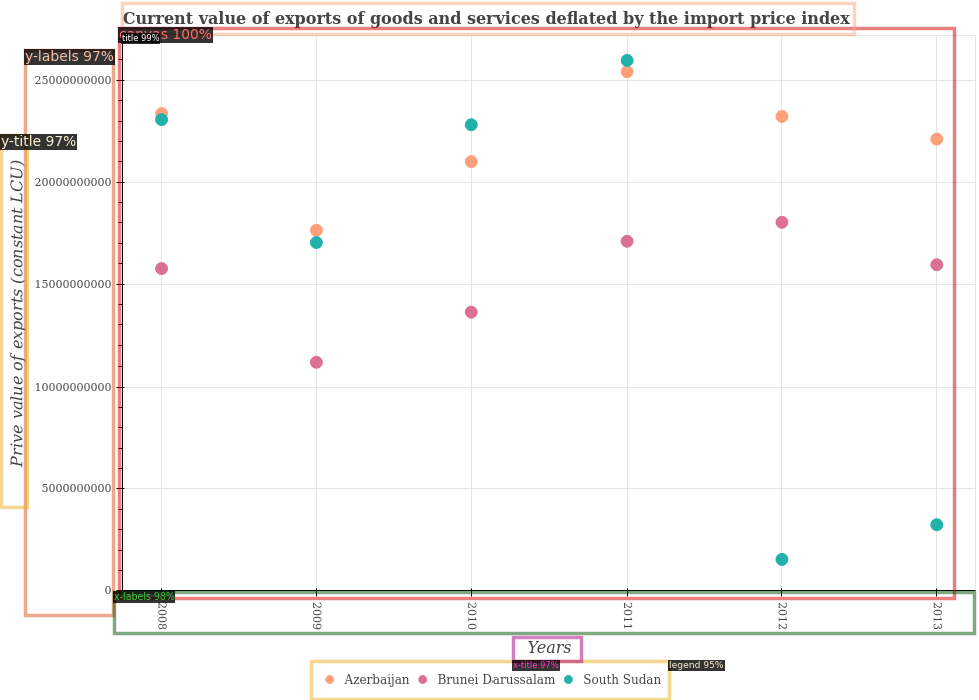

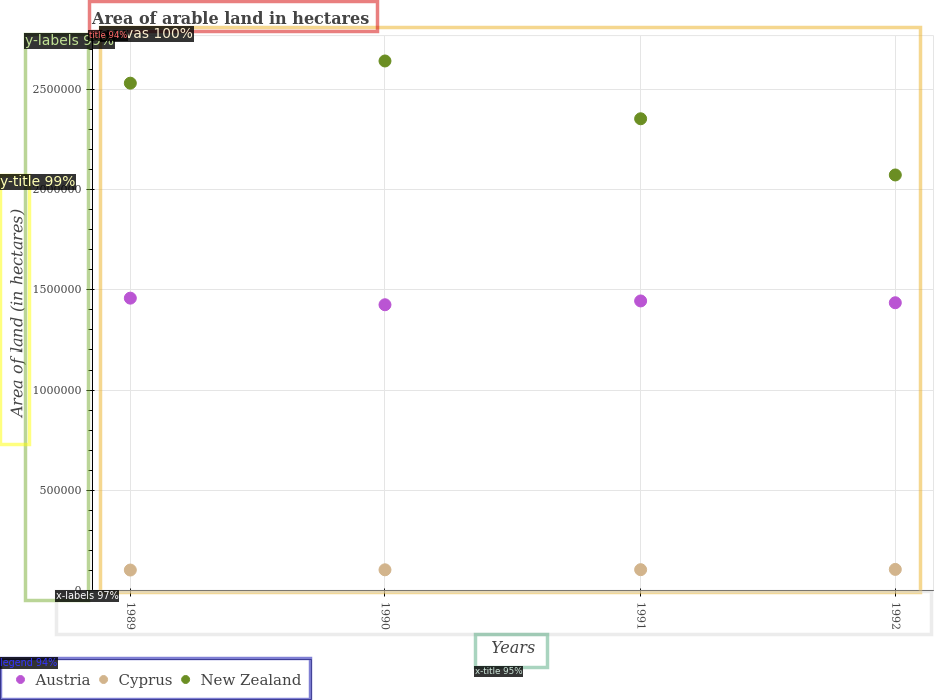

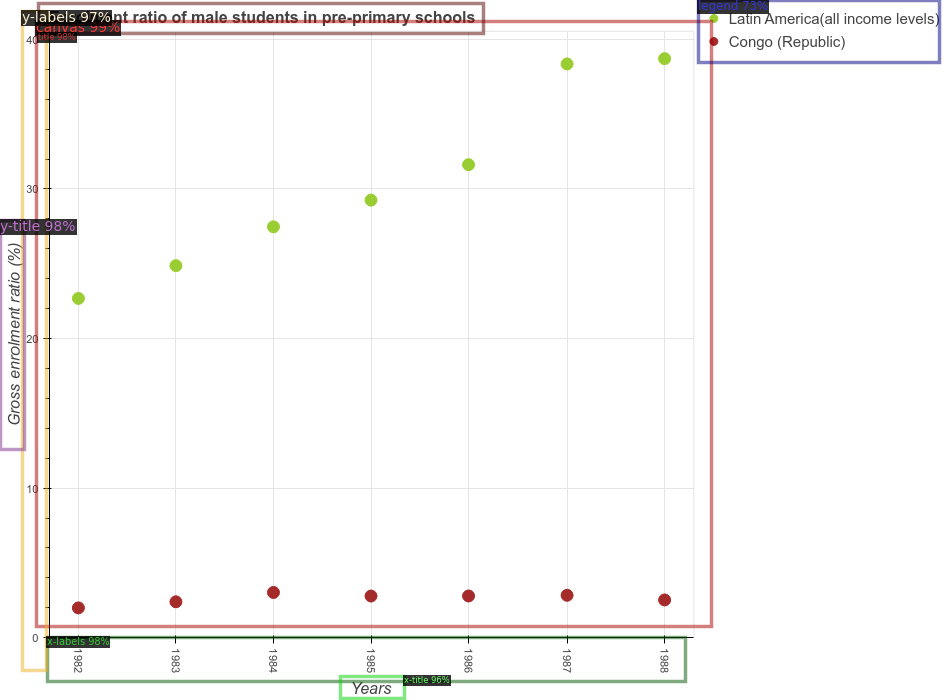

In [17]:
from detectron2.utils.visualizer import ColorMode

test_images_path = "/content/drive/MyDrive/Scatter Dataset/test/images"

test_images = os.listdir(test_images_path)

# Randomly select 3 images
random_images = random.sample(test_images, 3)

# Loop through the selected images and visualize predictions
for image_name in random_images:
    image_path = os.path.join(test_images_path, image_name)

    im = cv2.imread(image_path)

    # Perform inference
    outputs = predictor(im)

    v = Visualizer(
        im[:, :, ::-1],
        metadata=scatter_metadata,
        scale=1,
        instance_mode=ColorMode.IMAGE
    )

    instances = outputs["instances"].to("cpu")
    labels = instances.pred_classes.numpy()  # Get class indices
    scores = instances.scores.numpy()  # Get confidence scores
    boxes = instances.pred_boxes.tensor.numpy()  # Get bounding boxes

    # Get class names from metadata
    class_names = scatter_metadata.get("thing_classes", [])

    labels_text = [
        f"{class_names[i - 1] if 0 < i <= len(class_names) else 'Unknown'}: {scores[j]:.2f}"
        for j, i in enumerate(labels)
    ]

    # Draw predictions with labels
    out = v.draw_instance_predictions(instances)

    # Draw text labels on the image
    for box, label_text in zip(boxes, labels_text):
        x, y = int(box[0]), int(box[1])  # Top-left corner of the bounding box
        cv2.putText(out.get_image(), label_text, (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    cv2_imshow(out.get_image()[:, :, ::-1])

In [18]:
torch.save(predictor.model.state_dict(), "scatter_model_weights.pth")